In [1]:
import gstools as gs
from gstools import CovModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
import xarray as xr
import matplotlib.ticker as mticker
import warnings

In [2]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from multiprocess import Pool
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from cartopy import geodesic as cgeod
import os

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [10]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

In [4]:
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")

In [5]:
spec_id = 51026

In [6]:
df_season_scale = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)

In [7]:
df_stations_p90 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90_500km/{spec_id}_station_moving_list_all_events.csv")

In [11]:
fit_model = gs.Spherical(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
r_bins =  np.arange(1,520,25) #np.arange(1,370,20)#   np.arange(1,1520,25) #  
rmax = 501# 361#501
# Function to compute weighted mean of gamma for each bin
def weighted_mean(x,field="gamma"):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x[field] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0

bins_yfit_dict = {}
bins_scale_dict = {}
event_num_dict = {}
df_bins = pd.read_csv(f"./data/all_AU_p90_1960_500km/{spec_id}_pair_bins_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
# these are where the station number filter has been applied, I used y_fit for simplicity
df_bins = df_bins[ (df_bins["y_fit"]>0) & (df_bins["Bins"]<=rmax)] 
if len(df_bins)==0:
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = r_bins
        y_fit = np.zeros_like(bins)
        gamma = np.zeros_like(bins)
        scale = np.nan
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
else:
    df_bins["Date"] = pd.to_datetime(df_bins["Date"])
    df_bins["Season"] = df_bins["Date"].apply(get_season)
    df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
    mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
    df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
    ## normalise weight
    df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
    
    # Apply the weighted mean function per Season & Bin
    ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(lambda x: weighted_mean(x, field="gamma"), include_groups=False
                                                       ).reset_index(name="IVW_Gamma")
    # bins_yfit_dict = {}
    # bins_scale_dict = {}
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
        gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
        event_num_dict[seasons] = len(np.unique(df_bins[df_bins["Season"]==seasons]["Date"]))

        ## if have less than 10 events per season, this should not be considered
        if len(gamma)==0:# or len(df_bins[df_bins["Season"]==seasons])/r_bins.shape[0]<10:
            bins = r_bins
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = np.nan
            
        else:
            try:
                gamma_fit = gamma[gamma>0]
                bins_fit = bins[gamma>0]
                _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
                y_fit = fit_model.variogram(bins)
                # if fit_model.sill + fit_model.nugget<=0.5:
                scale = fit_model.len_scale
                # else:
                #     scale = range_from_gamma(fit_model, bins,gamma,0.95)
            except RuntimeError:
                # try:
                #     gamma_fit = gamma[gamma>0]
                #     bins_fit = bins[gamma>0]
                #     _ = fit_model.fit_variogram(bins_fit, gamma_fit,init_guess={"nugget":0})#, sill=0.5-0.025, nugget=0.025)
                #     y_fit = fit_model.variogram(bins)
                #     scale = fit_model.len_scale
                # except RuntimeError:
                    scale = fit_model.len_scale
                    y_fit = np.zeros_like(bins)
                    scale = np.nan
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
        bins_yfit_dict["Bins"] = bins

In [12]:
bins_scale_dict

{'DJF': 306.41250196171063,
 'MAM': 342.90636827374294,
 'JJA': 419.93001842232763,
 'SON': 371.01781678558024}

In [54]:
def run_sub(args):
    Nsmall = args[0]
    scale_arr = np.zeros(4).astype(float)
    df_bins = pd.read_csv(f"./data/all_AU_p90_1960_500km/{spec_id}_pair_bins_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
    # these are where the station number filter has been applied, I used y_fit for simplicity
    df_bins = df_bins[ (df_bins["y_fit"]>0) & (df_bins["Bins"]<=rmax)] 
    if len(df_bins)==0:
        for seasons in ["DJF", "MAM", "JJA", "SON"]:
            bins = r_bins
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = np.nan
            bins_yfit_dict[seasons+"_yfit"] = y_fit
            bins_yfit_dict[seasons+"_gamma"] = gamma    
            bins_scale_dict[seasons] = scale
    else:
        df_bins["Date"] = pd.to_datetime(df_bins["Date"])
        df_bins["Season"] = df_bins["Date"].apply(get_season)
        df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
        mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
        df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
        ## normalise weight
        df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
        
    
        for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
            ## subsampling
            unique_timestamps = np.unique(df_bins["Date"][df_bins["Season"]==seasons])
            selected_timestamps = np.random.choice(unique_timestamps, size=Nsmall, replace=False)
            df_sub = df_bins[df_bins["Date"].isin(selected_timestamps)]
            # Apply the weighted mean function per Season & Bin
            ivw_gamma = df_sub.groupby(["Season", "Bins"]).apply(lambda x: weighted_mean(x, field="gamma"), include_groups=False
                                                           ).reset_index(name="IVW_Gamma")
            bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
            gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
            event_num_dict[seasons] = len(np.unique(df_bins[df_bins["Season"]==seasons]["Date"]))
    
            ## if have less than 10 events per season, this should not be considered
            if len(gamma)==0:# or len(df_bins[df_bins["Season"]==seasons])/r_bins.shape[0]<10:
                bins = r_bins
                y_fit = np.zeros_like(bins)
                gamma = np.zeros_like(bins)
                scale = np.nan
                
            else:
                try:
                    gamma_fit = gamma[gamma>0]
                    bins_fit = bins[gamma>0]
                    _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
                    y_fit = fit_model.variogram(bins)
                    # if fit_model.sill + fit_model.nugget<=0.5:
                    scale = fit_model.len_scale
                    # else:
                    #     scale = range_from_gamma(fit_model, bins,gamma,0.95)
                except RuntimeError:
                    # try:
                    #     gamma_fit = gamma[gamma>0]
                    #     bins_fit = bins[gamma>0]
                    #     _ = fit_model.fit_variogram(bins_fit, gamma_fit,init_guess={"nugget":0})#, sill=0.5-0.025, nugget=0.025)
                    #     y_fit = fit_model.variogram(bins)
                    #     scale = fit_model.len_scale
                    # except RuntimeError:
                        scale = fit_model.len_scale
                        y_fit = np.zeros_like(bins)
                        scale = np.nan
            scale_arr[i] = scale 
    return scale_arr

In [80]:
max_pool =1
Nsmall = 15
Ntries = 1000
args_list = [(Nsmall,i) for i in range(0,Ntries)]
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(run_sub,
                   args_list),total=len(args_list),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()
scale_arr_15 = np.array(pool_outputs)


Processing seasonality: 100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


In [81]:
max_pool =1
Nsmall = 25
Ntries = 1000
args_list = [(Nsmall,i) for i in range(0,Ntries)]
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(run_sub,
                   args_list),total=len(args_list),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()
scale_arr_25 = np.array(pool_outputs)

Processing seasonality: 100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


In [82]:
max_pool =1
Nsmall = 30
Ntries = 1000
args_list = [(Nsmall,i) for i in range(0,Ntries)]
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(run_sub,
                   args_list),total=len(args_list),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()
scale_arr_30 = np.array(pool_outputs)


Processing seasonality: 100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


In [118]:
max_pool =1
Nsmall = 20
Ntries = 1000
args_list = [(Nsmall,i) for i in range(0,Ntries)]
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(run_sub,
                   args_list),total=len(args_list),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()
scale_arr_20 = np.array(pool_outputs)

Processing seasonality: 100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


In [88]:
max_pool =1
Nsmall = 10
Ntries = 1000
args_list = [(Nsmall,i) for i in range(0,Ntries)]
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(run_sub,
                   args_list),total=len(args_list),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()
scale_arr_10 = np.array(pool_outputs)

Processing seasonality: 100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


In [83]:
def plot_bin_curves(scale_var, bins = 200, range = (0,4)):
    count,binx,_ = plt.hist(scale_var[~np.isnan(scale_var)],bins=bins,range=range,facecolor="w")
    bin_centers = 0.5*(binx[1:]+binx[:-1])
    return bin_centers, count

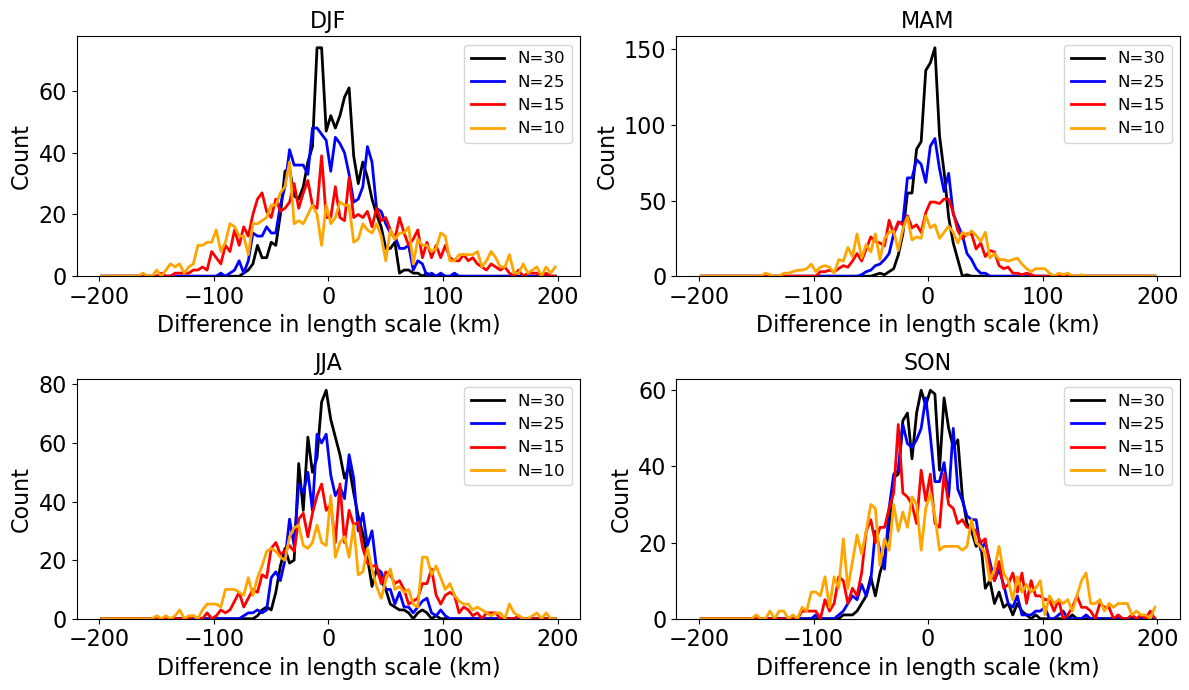

In [94]:
plt.figure()
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    plt.subplot(2,2,i+1)
    # _ = plt.hist(scale_arr_25[:,i]-bins_scale_dict[seasons],bins=200
    bin_centers, count = plot_bin_curves(scale_arr_30[:,i]-bins_scale_dict[seasons], bins = 100, range = (-200,200))
    plt.plot(bin_centers, count,color="k",label=f"N=30")
    bin_centers, count = plot_bin_curves(scale_arr_25[:,i]-bins_scale_dict[seasons], bins = 100, range = (-200,200))
    plt.plot(bin_centers, count,color="b",label=f"N=25")
    bin_centers, count = plot_bin_curves(scale_arr_15[:,i]-bins_scale_dict[seasons], bins = 100, range = (-200,200))
    plt.plot(bin_centers, count,color="r",label=f"N=15")
    bin_centers, count = plot_bin_curves(scale_arr_10[:,i]-bins_scale_dict[seasons], bins = 100, range = (-200,200))
    plt.plot(bin_centers, count,color="orange",label=f"N=10")
    plt.ylabel("Count")
    plt.xlabel("Difference in length scale (km)")
    plt.legend()
    plt.title(seasons)
    plt.tight_layout()

In [90]:
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    print(np.median(scale_arr_30[:,i]-bins_scale_dict[seasons]), np.median(scale_arr_25[:,i]-bins_scale_dict[seasons]),
          np.median(scale_arr_15[:,i]-bins_scale_dict[seasons]), np.median(scale_arr_10[:,i]-bins_scale_dict[seasons]))

0.9404628336888265 -1.709643265521322 -4.225939736179896 -4.253604203477522
0.5337145941358017 0.5411286118267356 1.6286910510077064 -0.9770346804503163
-0.5000400860048728 0.1082284451417479 1.2821097653619802 0.6896047869888378
1.3538051059578038 -0.18708496649929884 1.1908563727343733 0.22319579077532126


In [91]:
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    print(np.mean(scale_arr_30[:,i]-bins_scale_dict[seasons]), np.mean(scale_arr_25[:,i]-bins_scale_dict[seasons]),
          np.mean(scale_arr_15[:,i]-bins_scale_dict[seasons]), np.mean(scale_arr_10[:,i]-bins_scale_dict[seasons]))

0.6479582623430279 -0.19664624947937415 2.9920917819623014 5.169611454716489
-0.1888445240661436 -0.5797238485873817 -2.1156724876144506 -2.6386221406437684
1.0179794290979574 3.3209040895355155 6.5176315492419485 8.388830658201684
2.6651452488912 3.184633391140342 7.136490503242574 10.652187147754592


In [92]:
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    print(np.max(scale_arr_30[:,i]-bins_scale_dict[seasons]), np.max(scale_arr_25[:,i]-bins_scale_dict[seasons]),
          np.max(scale_arr_15[:,i]-bins_scale_dict[seasons]), np.max(scale_arr_10[:,i]-bins_scale_dict[seasons]))

85.62342322158867 108.19380824206183 188.5964235126197 231.78554638078356
33.876382338381745 51.06365460335411 88.24635359448445 132.33532594495335
95.36162720704613 103.28219600519242 166.8994519847164 291.907984101456
124.8175595748499 139.10718283949092 206.42827343158575 322.5394752688998


In [93]:
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    print(np.min(scale_arr_30[:,i]-bins_scale_dict[seasons]), np.min(scale_arr_25[:,i]-bins_scale_dict[seasons]),
          np.min(scale_arr_15[:,i]-bins_scale_dict[seasons]), np.min(scale_arr_10[:,i]-bins_scale_dict[seasons]))

-75.01205656947315 -92.3779393397977 -146.59258202246596 -163.71129099247307
-44.081200908515484 -56.95509360109776 -93.7751179213655 -142.35304931265983
-62.93332883795904 -75.74267759762955 -118.94992921788543 -150.35952379274283
-72.27340792924474 -98.08116850758955 -111.88960983923937 -148.48181697289235


In [112]:
def percent_diff(var1, var2):
    return ((var1-var2) / ((var1+var2) / 2) )*100

In [109]:
bins_scale_dict[seasons]


371.01781678558024

In [ ]:
plt.figure(figsize=(12,7))
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    plt.subplot(2,2,i+1)
    # _ = plt.hist(scale_arr_25[:,i]-bins_scale_dict[seasons],bins=200
    box_data = [percent_diff(scale_arr_30[:,i],bins_scale_dict[seasons]), percent_diff(scale_arr_25[:,i],bins_scale_dict[seasons]),
                percent_diff(scale_arr_20[:,i],bins_scale_dict[seasons]),
               percent_diff(scale_arr_15[:,i],bins_scale_dict[seasons]), percent_diff(scale_arr_10[:,i],bins_scale_dict[seasons])]
    _ = plt.boxplot(box_data)
    plt.xticks([1,2,3,4,5], ["N=30", "N=25","N=20", "N=15","N=10"])
    plt.xlabel("")
    plt.ylabel("Percent difference (%)")
    # plt.legend()
    plt.title(seasons)
    plt.tight_layout()

plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_sensitivity.png", dpi=200, bbox_inches="tight")